<a href="https://colab.research.google.com/github/Lenger3/Final_Project_Data/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
f="telemetry_subway_2025-10-30T15-07-51.116645"+".csv"
url = "https://raw.githubusercontent.com/Lenger3/Final_Project_Data/main/Data/"+f
f2="telemetry_walk_2025-10-27T18-55-28.325177"+".csv"
url2 = "https://raw.githubusercontent.com/Lenger3/Final_Project_Data/main/Data/"+f
df = pd.read_csv(url)
df2 = pd.read_csv(url2)

In [ ]:
df['total_horizontal_acc'].describe()

,total_horizontal_acc
count,7099.000000
mean,0.344417
std,0.549450
min,0.006550
25%,0.121063
50%,0.216217
75%,0.376466
max,8.800331


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

# --- Kendi DataFrame'ini Yükle ---
# df = pd.read_csv('senin_verilerin.csv') # veya .json, .feather vb.
# ...
# Bu noktada 'df'nin hazır ve dolu olduğunu varsayıyorum.
# İçinde 'yaw', 'pitch', 'roll',
# 'linear_acc_x', 'linear_acc_y', 'linear_acc_z' sütunları olmalı.

# Örnek olarak df'in ilk 5 satırını gösterelim (opsiyonel)
# print("İşlem Öncesi Orijinal Veri (İlk 5 satır):")
# print(df.head())

# ----- 2. HESAPLAMA KISMI -----

# VARSAYIMLAR:
# 1. Açıların 'derece' (degrees) cinsinden olduğunu varsayıyorum.
#    Eğer radyan ise 'degrees=True' kısmını sil.
# 2. Euler açılarının sırasının 'zyx' (yaw, pitch, roll) olduğunu varsayıyorum.
#    Bu sıra (z, y, x) sensörden sensöre değişebilir!
#    Hatalı sonuç alırsan 'xyz', 'yzx' gibi farklı sıraları denemen gerekebilir.

try:
    # Adım 1: Gerekli sütunları Numpy dizilerine çek (Tüm veriyi tek seferde işlemek için)

    # (N, 3) şeklinde bir lineer ivme vektörleri dizisi
    linear_vectors = df[['useracc_x', 'useracc_y', 'useracc_z']].values

    # (N, 3) şeklinde bir Euler açıları dizisi (yaw, pitch, roll)
    angles = df[['yaw_deg', 'pitch_deg', 'roll_deg']].values

    # Adım 2: Her satırın duruş açısına göre "Dönüşüm" nesneleri oluştur
    # 'zyx' sırası: yaw (Z), pitch (Y), roll (X) eksenlerinde döner.
    rotations = R.from_euler('zyx', angles, degrees=True)

    # Adım 3: İvmeyi "Dünya Eksenlerine" çevir (Device -> World)
    # 'inverse=True' ile dönüşümün tersini (cihazdan dünyaya) uygularız.
    world_acc_vectors = rotations.apply(linear_vectors, inverse=True)

    # world_acc_vectors artık [world_x, world_y, world_z] bileşenlerini içerir.
    # world_x: Kuzey/Güney yönlü ivme
    # world_y: Doğu/Batı yönlü ivme
    # world_z: Yukarı/Aşağı yönlü ivme

    # Adım 4: Toplam Yatay İvmeyi (magnitude) hesapla
    # Bu, "Dünya X" ve "Dünya Y" bileşenlerinin hipotenüsüdür.

    # world_acc_vectors[:, 0] -> tüm 'world_x' değerleri
    # world_acc_vectors[:, 1] -> tüm 'world_y' değerleri

    horizontal_acceleration = np.sqrt(
        world_acc_vectors[:, 0]**2 +
        world_acc_vectors[:, 1]**2
    )

    # Adım 5: Sonuçları yeni sütunlar olarak DataFrame'e ekle

    # Sadece yatay ivmeyi istiyordun, ama bileşenleri görmek de faydalı olabilir:
    df['world_acc_x'] = world_acc_vectors[:, 0]
    df['world_acc_y'] = world_acc_vectors[:, 1]
    df['world_acc_z'] = world_acc_vectors[:, 2]
    df['total_horizontal_acc'] = horizontal_acceleration


    print("\n--- Hesaplama Tamamlandı ---")
    print("DataFrame'e 'world_acc_x', 'world_acc_y', 'world_acc_z' ve 'total_horizontal_acc' eklendi.")
    print("\nSonuç (İlk 5 satır):")
    print(df[['total_horizontal_acc', 'world_acc_x', 'world_acc_y', 'world_acc_z']].head())

except ImportError:
    print("\nLÜTFEN 'scipy' kütüphanesini yükleyin: pip install scipy")
except KeyError as e:
    print(f"\nDataFrame'de sütun bulunamadı: {e}")
    print("Sütun adlarının ('yaw', 'pitch', 'roll', 'linear_acc_x' vb.) doğru olduğundan emin ol.")
except Exception as e:
    print(f"\nBir hata oluştu: {e}")
    print("Açıların 'derece' mi 'radyan' mı olduğunu veya Euler açı sırasını ('zyx') kontrol et.")


--- Hesaplama Tamamlandı ---
DataFrame'e 'world_acc_x', 'world_acc_y', 'world_acc_z' ve 'total_horizontal_acc' eklendi.

Sonuç (İlk 5 satır):
   total_horizontal_acc  world_acc_x  world_acc_y  world_acc_z
0              0.624090     0.073696     0.619723    -0.574890
1              0.624090     0.073696     0.619723    -0.574890
2              1.306977    -0.649193     1.134345     0.597753
3              1.306977    -0.637518     1.140947     0.597753
4              1.306977    -0.637518     1.140947     0.597753


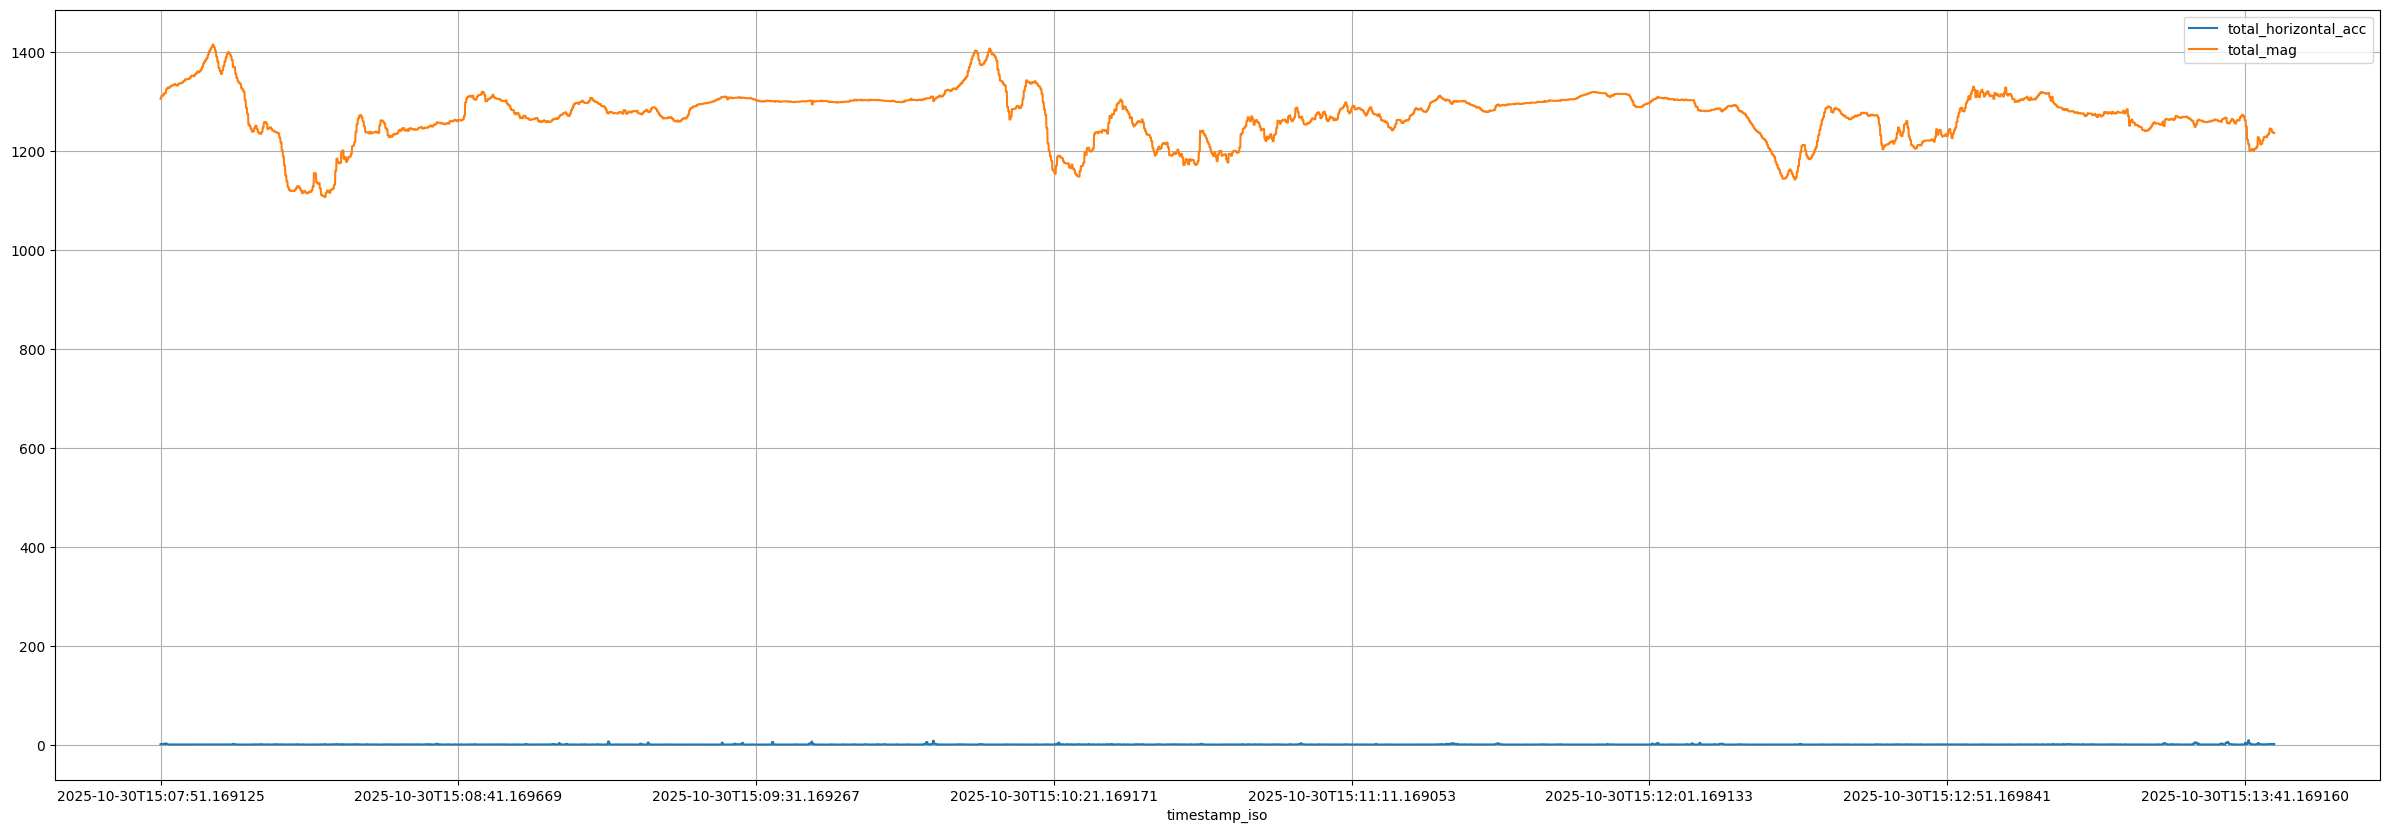

In [ ]:
import matplotlib.pyplot as plt
import math
magdf = df[['timestamp_iso','mag_x','mag_y','mag_z','useracc_x','useracc_y','useracc_z', 'world_acc_x', 'world_acc_y', 'world_acc_z','total_horizontal_acc']].copy()
magdf[['sqr_mag_x','sqr_mag_y','sqr_mag_z']] = magdf[['mag_x','mag_y','mag_z']].pow(2)
magdf[['useracc_x','useracc_y','useracc_z']] = magdf[['useracc_x','useracc_y','useracc_z']].pow(2)
magdf['total_mag'] = magdf[['sqr_mag_x','sqr_mag_y','sqr_mag_z']].sum(axis=1)
magdf['total_acc'] = magdf[['useracc_x','useracc_y','useracc_z']].sum(axis=1)
magdf['total_mag'] = magdf['total_mag'].apply(lambda x: math.sqrt(x))
magdf['total_acc'] = magdf['total_acc'].apply(lambda x: math.sqrt(x))
magdf.plot(x='timestamp_iso', y=['total_horizontal_acc','total_mag'], figsize=(30, 10))
plt.grid(True)

In [ ]:
display(df)

,timestamp_iso,session_ms,sample_idx,acc_x,acc_y,acc_z,useracc_x,useracc_y,useracc_z,gravity_x,...,mag_z,yaw_deg,pitch_deg,roll_deg,pressure_hpa,label,world_acc_x,world_acc_y,world_acc_z,total_horizontal_acc
0,2025-10-30T15:07:51.169125,51,0,3.955221,3.770868,8.145373,0.784329,-0.024598,-0.322816,3.170892,...,-1082.280029,-97.878,-23.781,24.842,NaN,subway,0.073696,0.619723,-0.574890,0.624090
1,2025-10-30T15:07:51.218850,101,1,3.955221,3.770868,8.145373,0.784329,-0.024598,-0.322816,3.170892,...,-1082.280029,-97.878,-23.781,24.842,NaN,subway,0.073696,0.619723,-0.574890,0.624090
2,2025-10-30T15:07:51.268947,151,2,3.445256,3.282450,9.909900,1.025341,-0.040140,1.006262,2.419915,...,-1082.280029,-107.489,-18.264,18.326,NaN,subway,-0.649193,1.134345,0.597753,1.306977
3,2025-10-30T15:07:51.318887,201,3,3.445256,3.282450,9.909900,1.025341,-0.040140,1.006262,2.419915,...,-1090.559937,-106.901,-18.264,18.326,NaN,subway,-0.637518,1.140947,0.597753,1.306977
4,2025-10-30T15:07:51.368909,251,4,3.445256,3.282450,9.909900,1.025341,-0.040140,1.006262,2.419915,...,-1090.559937,-106.901,-18.264,18.326,NaN,subway,-0.637518,1.140947,0.597753,1.306977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7094,2025-10-30T15:13:45.869921,354752,7094,-2.454057,7.135020,6.763919,1.199585,-0.260550,-0.804553,-3.653642,...,-1014.539978,-133.770,14.015,46.529,NaN,subway,-0.315104,1.432106,-0.063076,1.466362
7095,2025-10-30T15:13:45.919815,354801,7095,-2.454057,7.135020,6.763919,1.199585,-0.260550,-0.804553,-3.653642,...,-1010.339966,-133.988,14.015,46.529,NaN,subway,-0.320550,1.430897,-0.063076,1.466362
7096,2025-10-30T15:13:45.969758,354851,7096,-2.454057,7.135020,6.763919,1.199585,-0.260550,-0.804553,-3.653642,...,-1010.339966,-133.988,14.015,46.529,NaN,subway,-0.320550,1.430897,-0.063076,1.466362
7097,2025-10-30T15:13:46.018950,354901,7097,-2.454057,7.135020,6.763919,-0.790835,0.328985,-0.097704,-1.663221,...,-1010.339966,-133.988,14.015,46.529,NaN,subway,0.369599,-0.606692,-0.488384,0.710407


Grafik 'ikincil_eksenli_grafik_df.png' olarak kaydedildi.


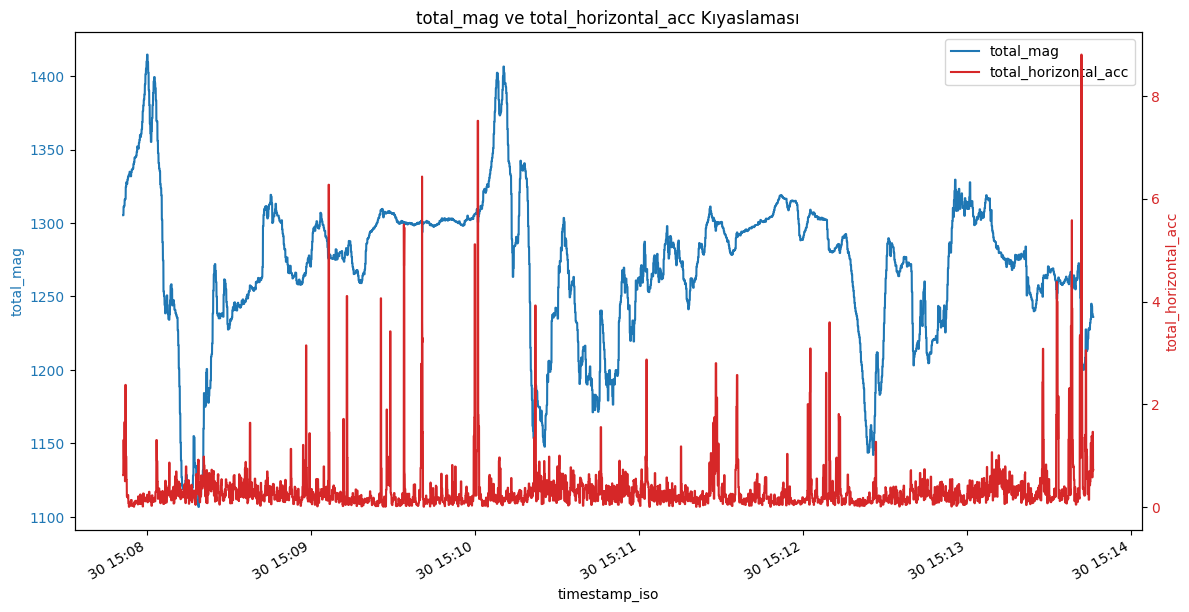

In [ ]:
# --- 2. DEĞİŞTİRMEN GEREKEN YERLER ---
# Lütfen bu değişkenleri kendi DataFrame'indeki sütun adlarıyla değiştir:
x_ekseni_sutun_adi = 'timestamp_iso'         # X ekseni için (örn: 'timestamp_iso' veya neyse o)
buyuk_veri_sutun_adi = 'total_mag'  # Y ekseni 1 (Büyük değerler)
kucuk_veri_sutun_adi = 'total_horizontal_acc'  # Y ekseni 2 (Küçük değerler)
# ----------------------------------------------------


# 3. Grafik Oluşturma
try:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # ax1: Soldaki Y Ekseni (Büyük Veri için)
    color = 'tab:blue'
    ax1.set_xlabel(x_ekseni_sutun_adi)
    ax1.set_ylabel(buyuk_veri_sutun_adi, color=color)
    # Veriyi df'ten çek:
    line1 = ax1.plot(magdf[x_ekseni_sutun_adi], magdf[buyuk_veri_sutun_adi], color=color, label=buyuk_veri_sutun_adi)
    ax1.tick_params(axis='y', labelcolor=color)

    # 4. İkincil Ekseni Oluşturma
    # ax1'in X eksenini paylaşan (twinx) yeni bir eksen (ax2) oluştur
    ax2 = ax1.twinx()

    # ax2: Sağdaki Y Ekseni (Küçük Veri için)
    color = 'tab:red'
    ax2.set_ylabel(kucuk_veri_sutun_adi, color=color)
    # Veriyi df'ten çek:
    line2 = ax2.plot(magdf[x_ekseni_sutun_adi], magdf[kucuk_veri_sutun_adi], color=color, label=kucuk_veri_sutun_adi)
    ax2.tick_params(axis='y', labelcolor=color)

    # 5. Efsane (Legend) Oluşturma
    # İki plot'tan gelen etiketleri tek bir efsanede birleştirmek
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best') # 'best' en uygun konumu seçer

    # Eğer X ekseni 'timestamp' ise, etiketlerin üst üste binmesini engelle
    if pd.api.types.is_datetime64_any_dtype(df[x_ekseni_sutun_adi]):
         fig.autofmt_xdate()

    fig.tight_layout() # Grafiğin sıkışık görünmesini engelle
    plt.title(f'{buyuk_veri_sutun_adi} ve {kucuk_veri_sutun_adi} Kıyaslaması')

    # Grafiği 'show()' yerine dosyaya kaydediyoruz
    plt.savefig('ikincil_eksenli_grafik_df.png')
    print("Grafik 'ikincil_eksenli_grafik_df.png' olarak kaydedildi.")

except KeyError as e:
    print(f"Hata: DataFrame'de '{e}' adında bir sütun bulunamadı.")
    print("Lütfen 2. adımdaki sütun adlarını kontrol et.")
    print(df.head())
except Exception as e:
    print(f"Bir hata oluştu: {e}")

In [ ]:
total_time = df2['timestamp_iso'].max() - df2['timestamp_iso'].min()
print(f"Total time between the two dataframes: {total_time}")

Total time between the two dataframes: 0 days 00:05:54.899792


In [ ]:
df['timestamp_iso'] = pd.to_datetime(df['timestamp_iso'])
df2['timestamp_iso'] = pd.to_datetime(df2['timestamp_iso'])

In [ ]:
windowed_data_df = []
windowed_data_df2 = []

for start_time in df['timestamp_iso'].unique():
    end_time = start_time + pd.Timedelta(seconds=window_size)
    window = df[(df['timestamp_iso'] >= start_time) & (df['timestamp_iso'] < end_time)].copy()
    if not window.empty:
        windowed_data_df.append(window)

for start_time in df2['timestamp_iso'].unique():
    end_time = start_time + pd.Timedelta(seconds=window_size)
    window = df2[(df2['timestamp_iso'] >= start_time) & (df2['timestamp_iso'] < end_time)].copy()
    if not window.empty:
        windowed_data_df2.append(window)

print(f"Number of windows in df: {len(windowed_data_df)}")
print(f"Number of windows in df2: {len(windowed_data_df2)}")

Number of windows in df: 7099
Number of windows in df2: 7099


# Task
Split the data in the `df_data` and `df_data_2` dataframes into 10-second windows based on the `timestamp_iso` column.

## Convert timestamp column to datetime objects

### Subtask:
Convert the `timestamp_iso` column in both dataframes to datetime objects to enable time-based operations.


**Reasoning**:
Convert the 'timestamp_iso' columns in both dataframes to datetime objects for time-based processing as requested in the instructions.



## Define window size

### Subtask:
Set the window size to 10 seconds.


**Reasoning**:
Set the window size to 10 seconds.



In [ ]:
window_size = 10

## Apply rolling window

### Subtask:
Iterate through the dataframes using a rolling window of 10 seconds to create smaller segments of data.


**Reasoning**:
Create empty lists to store the windowed data and iterate through the dataframes with a rolling window of size `window_size` seconds based on the `timestamp_iso` column, extracting and appending each window to the respective lists.



## Store windowed data

### Subtask:
Store each 10-second window of data as a separate entity (e.g., in a list of dataframes).


**Reasoning**:
Confirm the number of dataframes in the windowed lists and optionally inspect a few to ensure they represent 10-second intervals.



In [ ]:
print(f"Number of windows in windowed_data_df: {len(windowed_data_df)}")
print(f"Number of windows in windowed_data_df2: {len(windowed_data_df2)}")

# Optional inspection of the first few windows
if len(windowed_data_df) > 0:
    print("\nFirst window from windowed_data_df:")
    display(windowed_data_df[0].head())

if len(windowed_data_df2) > 0:
    print("\nFirst window from windowed_data_df2:")
    display(windowed_data_df2[0].head())

Number of windows in windowed_data_df: 9066
Number of windows in windowed_data_df2: 9066

First window from windowed_data_df:


,timestamp_iso,session_ms,sample_idx,acc_x,acc_y,acc_z,useracc_x,useracc_y,useracc_z,gravity_x,...,mag_y,mag_z,yaw_deg,pitch_deg,roll_deg,pressure_hpa,label,acc_x_smooth,acc_y_smooth,acc_z_smooth
0,2025-10-28 17:44:47.958556,51,0,-5.607520,0.964863,9.536405,-5.127440,-7.403616,8.186508,-0.480079,...,-1.44,-9.24,-2.749,30.329,5.777,NaN,walk,NaN,NaN,NaN
1,2025-10-28 17:44:48.007929,100,1,-5.607520,0.964863,9.536405,-5.127440,-7.403616,8.186508,-0.480079,...,-1.44,-9.24,-2.749,30.329,5.777,NaN,walk,NaN,NaN,NaN
2,2025-10-28 17:44:48.057941,150,2,-5.607520,0.964863,9.536405,-5.127440,-7.403616,8.186508,-0.480079,...,-1.44,-9.24,-2.749,30.329,5.777,NaN,walk,NaN,NaN,NaN
3,2025-10-28 17:44:48.108500,201,3,-5.607520,0.964863,9.536405,-5.671576,-8.679174,7.759217,0.064056,...,-1.44,-9.24,-2.749,30.329,5.777,NaN,walk,NaN,NaN,NaN
4,2025-10-28 17:44:48.158081,250,4,-3.888184,1.304840,7.273884,-5.671576,-8.679174,7.759217,1.783392,...,2.76,-18.18,-17.689,27.751,10.170,NaN,walk,NaN,NaN,NaN



First window from windowed_data_df2:


,timestamp_iso,session_ms,sample_idx,acc_x,acc_y,acc_z,useracc_x,useracc_y,useracc_z,gravity_x,...,mag_y,mag_z,yaw_deg,pitch_deg,roll_deg,pressure_hpa,label,acc_x_smooth,acc_y_smooth,acc_z_smooth
0,2025-10-28 17:44:47.958556,51,0,-5.607520,0.964863,9.536405,-5.127440,-7.403616,8.186508,-0.480079,...,-1.44,-9.24,-2.749,30.329,5.777,NaN,walk,NaN,NaN,NaN
1,2025-10-28 17:44:48.007929,100,1,-5.607520,0.964863,9.536405,-5.127440,-7.403616,8.186508,-0.480079,...,-1.44,-9.24,-2.749,30.329,5.777,NaN,walk,NaN,NaN,NaN
2,2025-10-28 17:44:48.057941,150,2,-5.607520,0.964863,9.536405,-5.127440,-7.403616,8.186508,-0.480079,...,-1.44,-9.24,-2.749,30.329,5.777,NaN,walk,NaN,NaN,NaN
3,2025-10-28 17:44:48.108500,201,3,-5.607520,0.964863,9.536405,-5.671576,-8.679174,7.759217,0.064056,...,-1.44,-9.24,-2.749,30.329,5.777,NaN,walk,NaN,NaN,NaN
4,2025-10-28 17:44:48.158081,250,4,-3.888184,1.304840,7.273884,-5.671576,-8.679174,7.759217,1.783392,...,2.76,-18.18,-17.689,27.751,10.170,NaN,walk,NaN,NaN,NaN


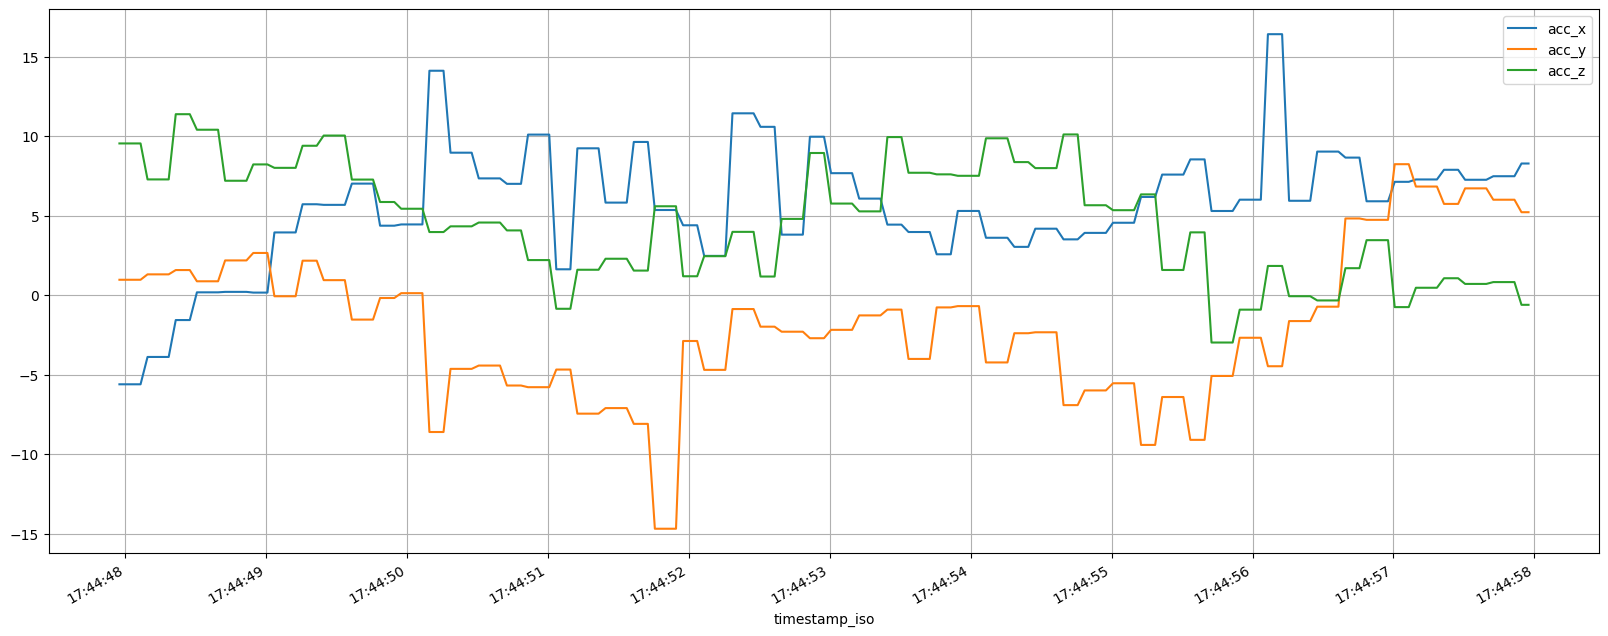

In [ ]:
windowed_data_df[0].plot(x='timestamp_iso', y=['acc_x','acc_y','acc_z'], figsize=(20, 8))
plt.grid(True)
plt.legend()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Both `windowed_data_df` and `windowed_data_df2` lists contain 9066 dataframes, representing the 10-second windows of data from the original `df_data` and `df_data_2` dataframes, respectively.
*   The inspection of the first window in each list showed data with timestamps that are close together, consistent with the start of a 10-second window.

### Insights or Next Steps

*   The windowed data is now ready for further analysis or processing on a per-window basis.
*   Consider analyzing the distribution of data points within each window to identify patterns or anomalies.
